In [56]:
import pandas as pd
import numpy as np
import networkx as nx 
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Para grafos
from pyvis import network as net # Visualizaciones
import networkx as nx # Métricas basadas en grafos

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [57]:
df=pd.read_csv('df.csv').drop('Unnamed: 0',axis=1)
df.head(2)

,reporter,partner,section,export_value_usd,continent_reporter,continent_partner
0,Afghanistan,Albania,Unspecified,42832,Asia,Europe
1,Afghanistan,United Arab Emirates,Unspecified,2485266,Asia,Asia


In [58]:
df.section.unique()

array(['Unspecified', 'Chemical Products', 'Plastics and Rubbers',
       'Textiles', 'Precious Metals', 'Machines', 'Instruments',
       'Vegetable Products', 'Foodstuffs', 'Animal Hides',
       'Wood Products', 'Paper Goods', 'Footwear and Headwear',
       'Transportation', 'Weapons', 'Metals', 'Miscellaneous',
       'Animal and Vegetable Bi-Products', 'Mineral Products',
       'Arts and Antiques', 'Stone And Glass', 'Animal Products'],
      dtype=object)

In [59]:
df = df[df.section=='Chemical Products'].copy()

In [70]:
df.continent_reporter.unique()

array(['Asia', 'Africa', 'Americas', 'Europe', 'Oceania'], dtype=object)

In [73]:
vertices=df.groupby(['reporter','continent_reporter'], as_index=False).export_value_usd.sum()
vertices.columns = ['pais','continente','export_value_usd']
vertices['export_value_usd'] = np.where(vertices.export_value_usd==0, 10, vertices.export_value_usd)
vertices['size'] = pd.qcut(vertices['export_value_usd'], 4, labels=[10,100,1000,2000])
vertices['color'] = np.select([vertices.continente == 'Asia', 
                               vertices.continente == 'Africa', 
                               vertices.continente == 'Americas',
                               vertices.continente == 'Europe',
                               vertices.continente == 'Oceania'],
                               ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0'], 
                               default='other')

vertices

,pais,continente,export_value_usd,size,color
0,Afghanistan,Asia,360346,100,#7fc97f
1,Albania,Europe,1241621,100,#ffff99
2,Algeria,Africa,9233605,1000,#beaed4
3,American Samoa,Oceania,581435,100,#386cb0
4,Andorra,Europe,1382785,100,#ffff99
...,...,...,...,...,...
221,Wallis and Futuna Isds,Oceania,16745,10,#386cb0
222,Western Sahara,Africa,68423,10,#beaed4
223,Yemen,Asia,68689,10,#7fc97f
224,Zambia,Africa,2049554,100,#beaed4


In [10]:
df=df.sort_values('export_value_usd',ascending=False).head(300).reset_index(drop=True).copy()

In [12]:
G = nx.from_pandas_edgelist(df = df, 
                            source = 'reporter',
                            target = 'partner',
                            edge_attr = True, 
                            create_using=nx.DiGraph()
                           )


In [13]:
edge_weight=[edge[2]['export_value_usd'] for edge in G.edges(data=True)]

In [14]:
attr_dict_grupo = vertices.set_index('pais')['color'].to_dict()
nx.set_node_attributes(G, 
                       values = attr_dict_grupo,
                       name = 'color')

attr_dict_grupo = vertices.set_index('pais')['size'].to_dict()
nx.set_node_attributes(G, 
                       values = attr_dict_grupo,
                       name = 'size')

In [15]:
node_size=[node[1]['size'] for node in G.nodes(data=True)]

In [16]:
node_colors=[node[1]['color'] for node in G.nodes(data=True)]


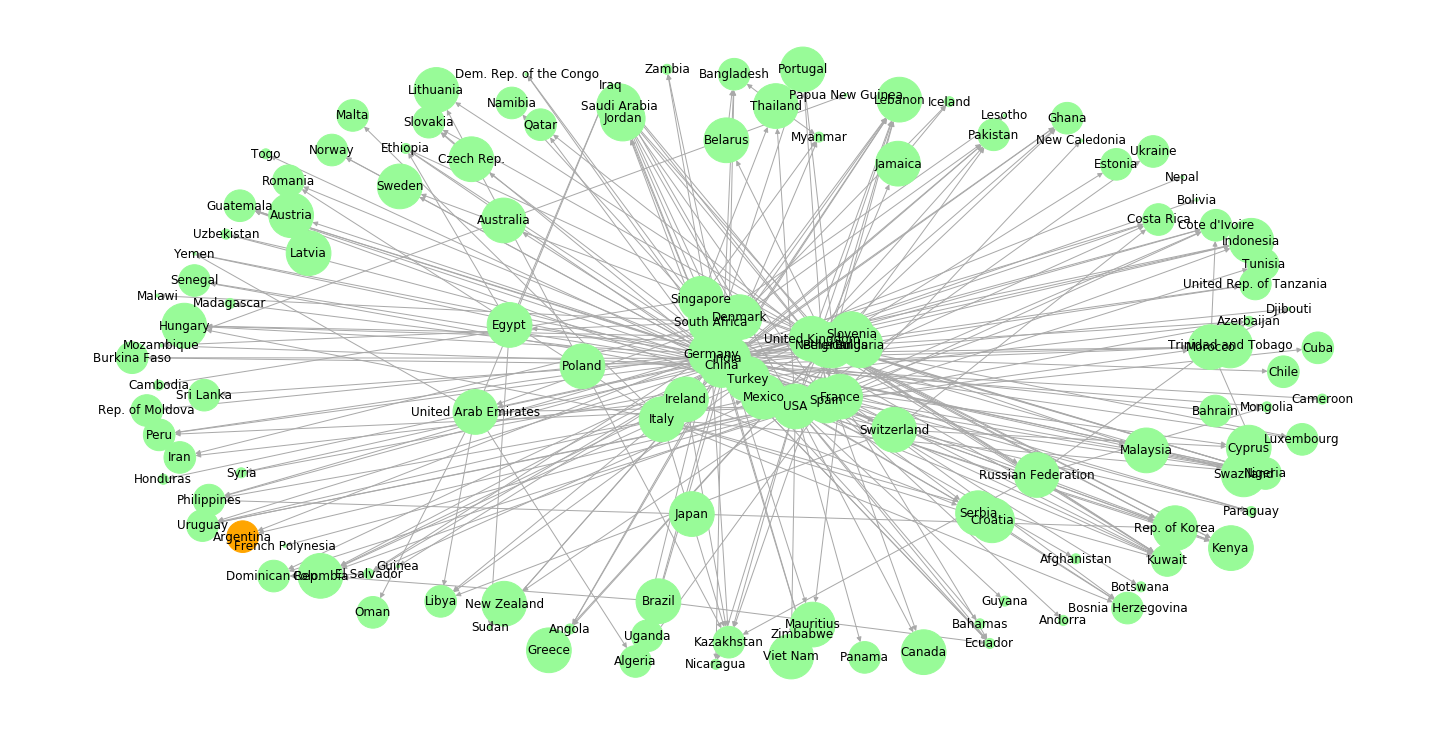

In [17]:
plt.figure(figsize=(20,10))

nx.draw(G, 
        with_labels=True, 
        node_color=node_colors,
        node_size=node_size, 
        weight=edge_weight,
        edge_color='darkgray')

plt.show()

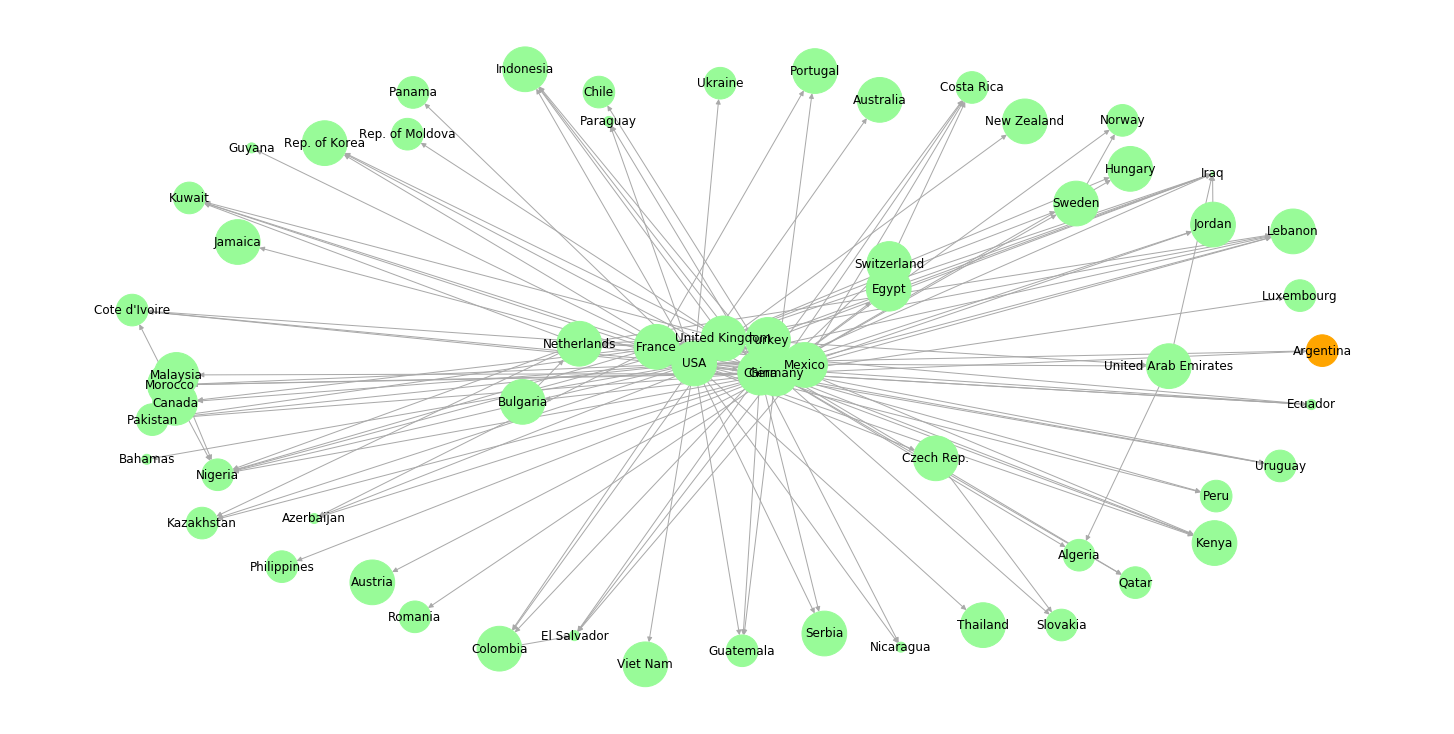

In [18]:
S=nx.ego_graph(G, 
               'Argentina', 
               radius=2, # Defino qué radio de vecinos busco (1: vecinos conectados por un enlace, 2 son los vecinos de sus vecinos, etc.)
               center=True, 
               undirected=True, 
               distance=None)

plt.figure(figsize=(20,10))

node_colors=[node[1]['color'] for node in S.nodes(data=True)]
node_size=[node[1]['size'] for node in S.nodes(data=True)]

cant_nodos = S.number_of_nodes()
pos = nx.spring_layout(S, 
                       k = 1/math.sqrt(cant_nodos)*3,
                       seed = 42)

nx.draw(S, 
        pos=pos,
        with_labels=True, 
       node_color=node_colors,
       node_size=node_size, 
       edge_color='darkgray')

plt.show()

In [86]:
df = pd.read_csv('df.csv').drop('Unnamed: 0', axis=1)
df = df[df.reporter!=df.partner].copy()
dffilt = df[df.section=='Chemical Products'].copy()

vertices=dffilt.groupby(['reporter','continent_reporter'], as_index=False).export_value_usd.sum()
vertices.columns = ['pais','continente','export_value_usd']
vertices['export_value_usd'] = np.where(vertices.export_value_usd==0, 10, vertices.export_value_usd)
vertices['size'] = pd.qcut(vertices['export_value_usd'], 4, labels=[10,100,1000,2000])
vertices['color'] = np.select([vertices.continente == 'Asia', 
                               vertices.continente == 'Africa', 
                               vertices.continente == 'Americas',
                               vertices.continente == 'Europe',
                               vertices.continente == 'Oceania'],
                               ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0'], 
                               default='other')

dffilt = dffilt.sort_values('export_value_usd',ascending=False).head(300).reset_index(drop=True).copy()
dffilt.shape

(300, 6)

In [89]:
len(network.edges)

300

In [ ]:
network.show("grafo_grupo0.html")

In [93]:
df = pd.read_csv('df.csv').drop('Unnamed: 0', axis=1)
df = df[df.reporter!=df.partner].copy()
dffilt = df[df.section=='Chemical Products'].copy()

vertices=dffilt.groupby(['reporter','continent_reporter'], as_index=False).export_value_usd.sum()
vertices.columns = ['pais','continente','export_value_usd']
vertices['export_value_usd'] = np.where(vertices.export_value_usd==0, 10, vertices.export_value_usd)
vertices['size'] = pd.qcut(vertices['export_value_usd'], 4, labels=[10,100,1000,2000])
vertices['color'] = np.select([vertices.continente == 'Asia', 
                               vertices.continente == 'Africa', 
                               vertices.continente == 'Americas',
                               vertices.continente == 'Europe',
                               vertices.continente == 'Oceania'],
                               ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0'], 
                               default='other')

dffilt = dffilt.sort_values('export_value_usd',ascending=False).head(300).reset_index(drop=True).copy()

network = Network(
    height="2000px", 
    width="100%", 
    bgcolor="white", 
    font_color="black",
    notebook=True, 
    directed=True
)

edge_data = zip(dffilt['reporter'], 
                dffilt['partner'], 
                dffilt['export_value_usd'])

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    network.add_node(src, src, title=src)
    network.add_node(dst, dst, title=dst)
    network.add_edge(src, dst, value=w)

# add neighbor data to node hover data
for node in network.nodes:
    if node['id'] in list(vertices['pais']):
        node['value']=int(vertices.loc[vertices.pais==node['id'],'export_value_usd'].values[0])
        node['title']=node['title']+"<br>Export: "+str(vertices.loc[vertices.pais==node['id'],'export_value_usd'].values[0])
        node['color']=str(vertices.loc[vertices.pais==node['id'],'color'].values[0])


network.set_options("""
        var options = {
          "nodes": {
            "borderWidth": 0,
            "borderWidthSelected": 4,
            "fixed": {
              "x": false,
              "y": false
            },
            "font": {
              "size": 13,
              "strokeWidth": 3

            },
            "shape": "dot"
          },
          "edges": {
               "color": {"inherit": true},
               "smooth": {"type": "horizontal", 
                          "type": "continuous",
                          "forceDirection": "none", 
                          "roundness": 0},
               "arrows": {"to": {"enabled": true}},
               "arrowStrikethrough": false,
               "selectionWidth": 7

          },
          "interaction": {
            "dragNodes": true,
            "hideEdgesOnDrag": false
          },
          "physics": {
               "enabled": true,
               "barnesHut": {"gravitationalConstant": -40000, "springLength": 100,
                             "springConstant": 0.01},
               "minVelocity": 5
         }
        }
        """) 

 

network.show("grafo_grupo0.html")

In [121]:
from math import log, floor

def human_format(number):
    units = ['', 'K', 'M', 'G', 'T', 'P']
    k = 1000.0
    magnitude = int(floor(log(number, k)))
    return '%.1f%s' % (number / k**magnitude, units[magnitude])




['42.8K',
 '2.5M',
 '8.4K',
 '155.0',
 '1.0K',
 '1.6K',
 '308.0',
 '474.0',
 '4.5K',
 '10.1K',
 '5.2K',
 '373.0',
 '5.3K',
 '106.7K',
 '920.0',
 '2.2K',
 '8.4K',
 '117.1K',
 '4.8K',
 '60.7K',
 '1.2K',
 '13.4K',
 '11.1K',
 '74.0',
 '21.0',
 '1.5K',
 '4.9K',
 '477.0',
 '7.2K',
 '320.0',
 '344.4K',
 '14.4K',
 '3.1K',
 '76.0',
 '796.0',
 '81.0',
 '877.0',
 '833.0',
 '62.0',
 '11.0',
 '351.0',
 '293.4K',
 '107.0',
 '28.0',
 '41.0',
 '1.3K',
 '380.0',
 '149.0',
 '111.3K',
 '136.9K',
 '3.7K',
 '8.9K',
 '162.0',
 '242.0',
 '105.0',
 '330.0',
 '468.0',
 '2.5K',
 '16.9K',
 '9.0',
 '614.0',
 '2.2M',
 '3.8K',
 '6.6K',
 '16.4K',
 '7.5K',
 '663.2K',
 '5.3K',
 '33.8K',
 '2.9K',
 '154.5K',
 '389.2K',
 '57.0',
 '3.1K',
 '3.0K',
 '5.0M',
 '6.6K',
 '183.0',
 '105.1K',
 '101.0',
 '1.3K',
 '15.9M',
 '104.0',
 '2.2K',
 '2.8K',
 '1.6K',
 '16.0',
 '1.1K',
 '11.9K',
 '13.4K',
 '138.0',
 '590.0',
 '555.0',
 '1.5K',
 '5.7K',
 '655.0',
 '652.0',
 '11.3K',
 '1.3K',
 '412.0',
 '334.0',
 '533.0',
 '52.0',
 '64.0',
 

In [ ]:
#%%writefile app.py

# ======= Libraries =======

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input,Output,State
import pandas as pd
from pyvis.network import Network
import visdcc
import numpy as np
#import re
#import dash_table
#import networkx as nx 
#import plotly.express as px
#import plotly.graph_objs as go

def human_format(number):
    if number!=0:
        units = ['', 'K', 'M', 'G', 'T', 'P']
        k = 1000.0
        magnitude = int(floor(log(number, k)))
        return '%.1f%s' % (number / k**magnitude, units[magnitude])
    else:
        return 0

df = pd.read_csv('df.csv').drop('Unnamed: 0', axis=1)
df = df[df.reporter!=df.partner].copy()

sections = pd.DataFrame({'section': df['section'].unique()}).sort_values('section')

network = Network( 
    bgcolor="white", 
    font_color="black",
    notebook=True, 
    directed=True
)


config_layout={
   'height': '1000px', 'width': '100%',
   "nodes": {
       "borderWidth": 0,
       "borderWidthSelected": 7,
       "fixed": {"x": False, "y": False},
       "font": {"size": 13, "strokeWidth": 3, 'color':'black'},
       "shape": "dot",
       'shapeProperties': {
           'interpolation': False
       }
   },
   "edges": {
       "color": {"inherit": True},
       "smooth": {"type": "horizontal", "forceDirection": "none", "roundness": 0},
       "arrows": {"to": {"enabled": True}},
       "arrowStrikethrough": False,
       "selectionWidth": 5

   },
   "interaction": {"dragNodes": True,
                   "hideEdgesOnDrag": False,
                   "multiselect": False,
                   "navigationButtons": True},
   "physics": {
       "enabled": True,
       "stabilization":True,
       "barnesHut": {"gravitationalConstant": -40000, "springLength": 100,
                     "springConstant": 0.01},
       "minVelocity": 0.75,
       "maxVelocity": 50
}}




# ======= APP =======
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
server = app.server

app.layout = html.Div([
    html.H1('Relaciones comerciales'),
    html.H4('Red de exportaciones por tipo exportación (2018, USD)'),
    html.Div([
        html.Div([
            dcc.Dropdown(id ='input_section',
                         options=[{'label': i, 'value': i} for i in sections.section.unique()],
                         multi=False,
                         value='Chemical Products',
                         clearable=False),
        ], className='six columns'),
    ], className='row'),
    visdcc.Network(id='network',
                   data={'nodes': network.nodes,'edges': network.edges},
                   options=config_layout)
])


@app.callback(
    Output('network', 'data'),
    [Input('input_section', 'value')]
)
def update_output(value):
    
    dffilt = df[df.section==value].copy()
    dffilt = dffilt.sort_values('export_value_usd',ascending=False).head(300).reset_index(drop=True).copy()
    
    vertices=dffilt.groupby(['reporter','continent_reporter'], as_index=False).export_value_usd.sum().copy()
    vertices.columns = ['pais','continente','export_value_usd']
    vertices2=dffilt.loc[~dffilt.partner.isin(vertices.pais.unique()),['partner','continent_partner']]
    vertices2['export_value_usd']=0
    vertices2.columns = ['pais','continente','export_value_usd']
    vertices = pd.concat([vertices,vertices2],axis=0)
    vertices['color'] = np.select([vertices.continente == 'Asia', 
                                   vertices.continente == 'Africa', 
                                   vertices.continente == 'Americas',
                                   vertices.continente == 'Europe',
                                   vertices.continente == 'Oceania'],
                                   ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0'], 
                                   default='other')
    vertices['label']=[human_format(i) for i in vertices.export_value_usd]

    network = Network(bgcolor="white",font_color="black",notebook=False,directed=True)
    edge_data = zip(dffilt['reporter'], dffilt['partner'], dffilt['export_value_usd'])

    for e in edge_data:
        src = e[0]
        dst = e[1]
        w = e[2]
        network.add_node(src, src, title=src)
        network.add_node(dst, dst, title=dst)
        network.add_edge(src, dst, value=w)

    for node in network.nodes:
        if node['id'] in list(vertices['pais']):
            node['value']=int(vertices.loc[vertices.pais==node['id'],'export_value_usd'].values[0])
            node['title']=node['title']+"<br>Export: "+str(vertices.loc[vertices.pais==node['id'],'label'].values[0])
            node['color']=str(vertices.loc[vertices.pais==node['id'],'color'].values[0])

    data ={'nodes': network.nodes,
           'edges': network.edges}
    
    return data



if __name__ == '__main__':
    app.run_server()


Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

INFO:__main__:Dash is running on http://127.0.0.1:8050/



INFO:__main__: Warning: This is a development server. Do not use app.run_server


 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production W

INFO:__main__: in production, use a production WSGI server like gunicorn instead.



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
INFO:werkzeug: * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [21/Aug/2020 19:26:59] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2020 19:26:59] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 19:26:59] "GET /_dash-layout HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2020 19:26:59] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 19:26:59] "GET /_dash-dependencies HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2020 19:26:59] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 19:27:00] "GET /assets/img/network/upArrow.png HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2020 19:27:00] "GET /assets/img/network/upArrow.png HTTP/1.1" 404 -
127.0.0.1 - - [21/Aug/2020 19:27:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 19:27:00] "GET /assets/img/network/downArrow.png HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [21/Aug

In [21]:
print(np.__version__)

1.17.1


In [148]:


vertices

,pais,continente,export_value_usd,color,label
0,Australia,Oceania,578247114,#386cb0,578.2M
1,Belarus,Europe,80507400,#ffff99,80.5M
2,Belgium,Europe,7269575715,#ffff99,7.3G
3,Brazil,Americas,487800145,#fdc086,487.8M
4,Bulgaria,Europe,188382795,#ffff99,188.4M
...,...,...,...,...,...
295,Dominican Rep.,Americas,0,#fdc086,0
296,Guinea,Africa,0,#beaed4,0
297,Bermuda,Americas,0,#fdc086,0
298,Costa Rica,Americas,0,#fdc086,0
